In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
import scipy.signal as signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
import plotly.express as px

import os
import sys
sys.path.append("..")
from structureSelector import *
from methods.utils.utilities import *

def recursiveMQ(y, phi, pad):
    size = phi.shape[1]
    nit = y.shape[0]
    p = 1000 * np.eye(size)
    teta = np.zeros((size, 1))

    erro = np.zeros(nit)
    print(phi.shape, nit)

    for t in range(0, nit):
        fi = phi[t,:]
        fi = fi.reshape(-1, 1)
        #print(teta, fi.T,'\n')
        erro[t] = y[t] - np.dot(teta.T, fi)
        k = np.dot(np.dot(p, fi), 1 / (1 + np.dot(np.dot(fi.T, p), fi)))
        teta = teta + np.dot(k, erro[t])
        p = p - np.dot(np.dot(k, fi.T), p)

    return np.squeeze(teta)


def integrate(p, ts=0.1):
    r = np.zeros(p.shape)
    r[0] = p[0] * ts
    for i in range(1, p.shape[0]):
        r[i] = r[i-1] + p[i] * ts
    return r


In [2]:
ballbeam  = np.loadtxt('../data/ballbeam.dat')
#ballbeam  = np.loadtxt('../data/teste.dat')

print(ballbeam.shape)
part = 500#ballbeam.shape[0] // 2#700

u = ballbeam[:part, 0].reshape((1,-1))
y = ballbeam[:part, 1].reshape((1,-1))

#u -= u[0,0]

wn = 0.1
b1, a1 = signal.butter(4, wn, 'low')

filtered = signal.filtfilt(b1, a1, y, padlen=100)

dy = np.zeros(filtered.shape)
dy[:, 1:] = (filtered[0, 1:] - filtered[0, :-1]) / 0.1

t = np.arange(0, part/10, 0.1)

fig=px.line(x=t, y=y[0].T, height=400, width=1300)
fig.add_scatter(x=t, y=filtered[0].T ,mode='lines')
fig.show()

wn = 0.2
b1, a1 = signal.butter(5, wn, 'low')
ufiltered = signal.filtfilt(b1, a1, u, padlen=100)
ufiltered[0, :15] = 0
U = integrate(ufiltered.T, 0.5).T

fig=px.line(x=t, y=dy[0].T, height=400, width=1300)
fig.add_scatter(x=t, y=U[0].T, mode='lines')
fig.add_scatter(x=t, y=ufiltered[0].T, mode='lines')
fig.show()

new_signal = pd.read_csv('../data/signal.csv')

(1000, 2)


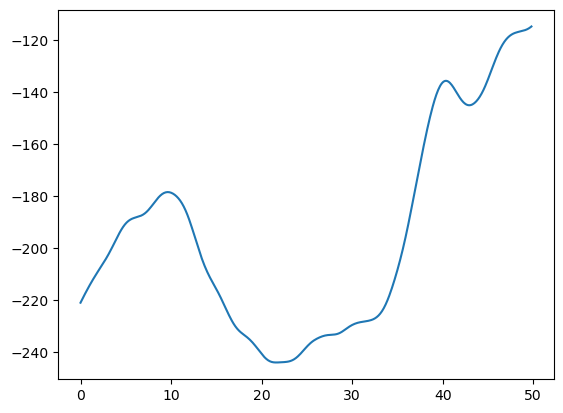

In [81]:
'''lower = 20
upper = 100
plt.plot(dy[0, lower:upper].T, '-o')
plt.plot(U[0, lower:upper].T, '-o')
plt.show()'''
un = np.array(new_signal['u']).reshape(1, -1)
zn = np.array(new_signal['z']).reshape(1, -1)
#zn = np.array(new_signal['z'] / new_signal['z'][0]).reshape(1, -1)
plt.plot(t[:-1], zn.T)
plt.show()

In [ ]:
du = np.zeros(ufiltered.shape)
du[:, 1:] = (ufiltered[0, 1:] - ufiltered[0, :-1]) / 0.1

d2y = np.zeros(ufiltered.shape)
d2y[:, 1:] = (dy[0, 1:] - dy[0, :-1]) / 0.1

nu = np.zeros(ufiltered.shape)
for i in range(1, ufiltered.shape[1]):
    nu[0, i] = nu[0, i-1] + (0.85 * (nu[0, i-1] - nu[0, i-2]) + 0.2 * du[0, i-1]) * 0.1

fig=px.line(x=t, y=ufiltered[0].T * 5, height=400, width=1300)
fig.add_scatter(x=t, y=d2y[0].T, mode='lines')
fig.add_scatter(x=t, y=nu[0].T * 10, mode='lines')
fig.show()

In [ ]:
du = np.zeros(filtered.shape)
du[:, 1:] = (ufiltered[0, 1:] - ufiltered[0, :-1]) / 0.1
g = filtered * du**2
plt.axhline(y=0, color='red')
plt.plot(g.T)
plt.show()

7 (7, 496)
[Y1.1 Y1.2 Y1.3 U1.1 U1.2]
0.500010500672488*U1.1 - 1.07377082656512e-5*U1.2 + 2.983955461112*Y1.1 - 2.96659979950675*Y1.2 + 0.982645356899248*Y1.3
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, U1.0, U1.1, U1.2, U1.3]


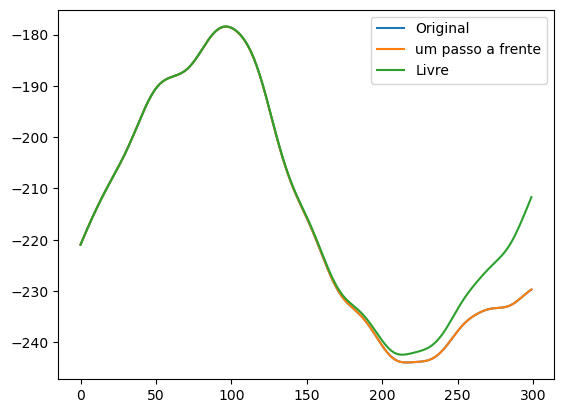

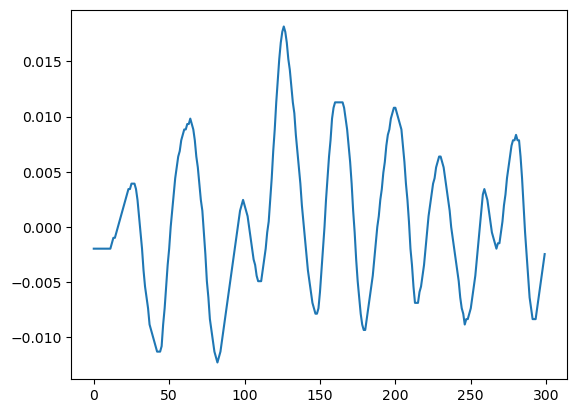

In [88]:
output = 0  # 0 ou 1
num = [6]
params = []
params.append({'nb':[3],'na':[3], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False})
#params.append({'nb':[1],'na':[20], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':5, 'diff':True})#10

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)

vCandidatos = sselector.matrix_candidate(un, zn, **params[output], dt=0.1, intg=False)

print(len(ss), vCandidatos.shape)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, zn[output, pad:], num[output], 0.00000000001)

#model = ss[selected]
#print(model, selected)

theta = LSM(zn[output, pad:], psi)
#theta1 = recursiveMQ(zn[output, pad:], psi, pad)

model = ss[selected]
pprint(model)
print(model @ theta)


slivre = sselector.predict(un, zn, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(un, zn, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)

fim = 300
s = 0#t-20
plt.plot(zn[output, s:fim].T, label='Original')
plt.plot(yhat[s:fim], label='um passo a frente')
plt.plot(slivre[s:fim], label='Livre')
plt.legend()
plt.show()
plt.plot(un[0,s:fim].T)

In [69]:
theta1

array([ 2.96448964, -2.92782559,  0.96333673,  0.48309422])